## Algorithm Assisted Day Trading (Data Wrangling, EDA, Modeling)

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
import tensorflow as tf

import matplotlib.pyplot as plt 
import seaborn as sns 
from pylab import rcParams
plt.style.use('fivethirtyeight')

from pandas_datareader.data import DataReader
from datetime import date

# Pre_processing and modeling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 1. Importing Data

In [2]:
# Setting Dates
start= date(2005,1,1)
end= date(2020,1,1)

In [3]:
# importing data
## JP Morgan
jpm=DataReader('JPM', data_source='yahoo',start=start, end=end)
jpm.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-27,139.770004,138.669998,139.300003,139.139999,7868200.0,134.264221
2019-12-30,140.080002,138.470001,139.899994,138.630005,6963000.0,133.772079
2019-12-31,139.479996,138.289993,138.509995,139.399994,7201600.0,134.515091


In [4]:
#creating two datasets that might be useful later
jpm_first_years=jpm['2005':'2018']
jpm_last_year=jpm['2019']

### 2. Visualizing Data

#### 2.0 Visualization of the data

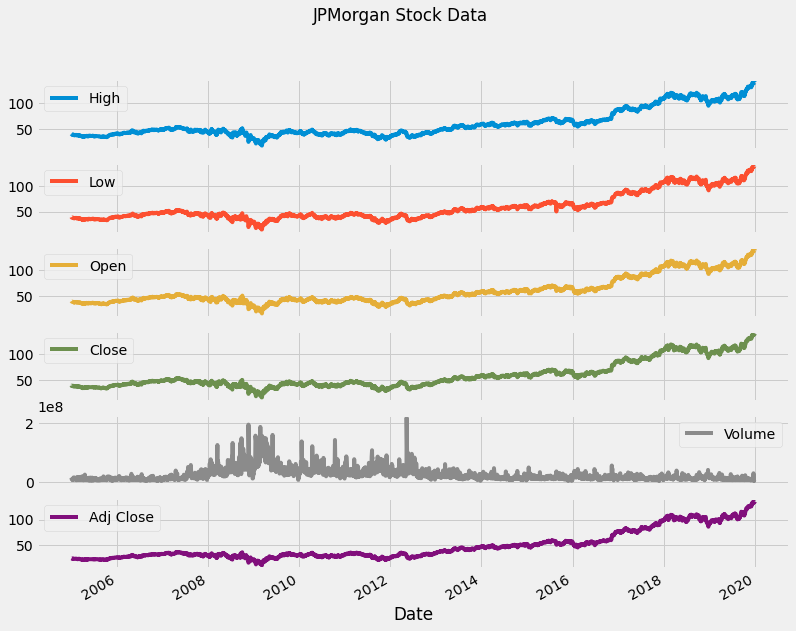

In [5]:
#JPMorgan
jpm.plot(subplots=True, figsize=(12,10),title='JPMorgan Stock Data')
plt.show()
# Here we the price of the stock going down between 2009 and 2010 
## yet the amount of stocks traded increased

#### 2.1 Monthly Visualization of the data

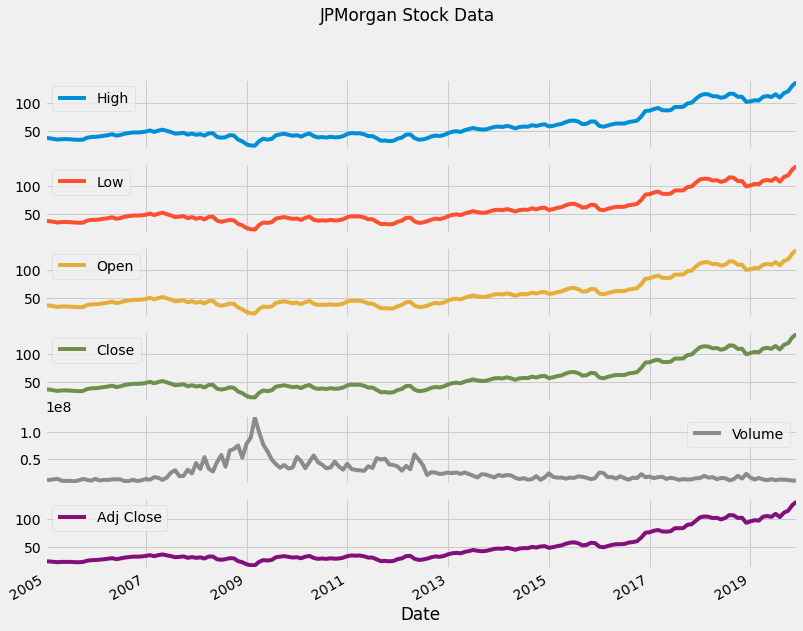

In [6]:
jpm.resample(rule='M').mean().plot(subplots=True, figsize=(12,10),title='JPMorgan Stock Data')
plt.show()
# we can see the same trends as above but more clearly that in later month in 2008 to early months in 2009 the price dropped

#### 2.2 Yearly Visualization of the data

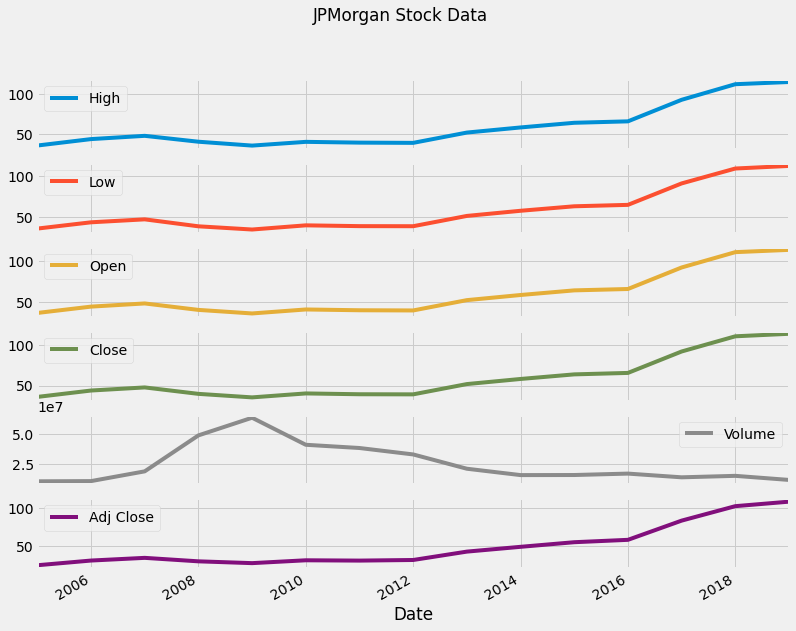

In [7]:
jpm.resample(rule='A').mean().plot(subplots=True, figsize=(12,10),title='JPMorgan Stock Data')
plt.show()

#### 2.3 Moving Averages

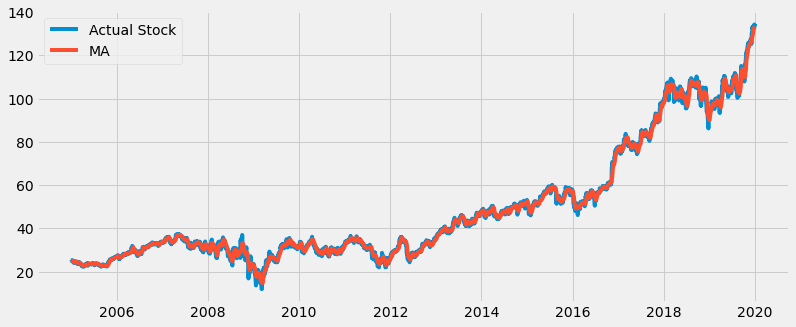

In [8]:
# A 14 days moving Average
plt.figure(figsize=(12,5))
plt.plot(jpm['Adj Close'], label='Actual Stock')
plt.plot(jpm.rolling('14D').mean()['Adj Close'], label='MA')
plt.legend()

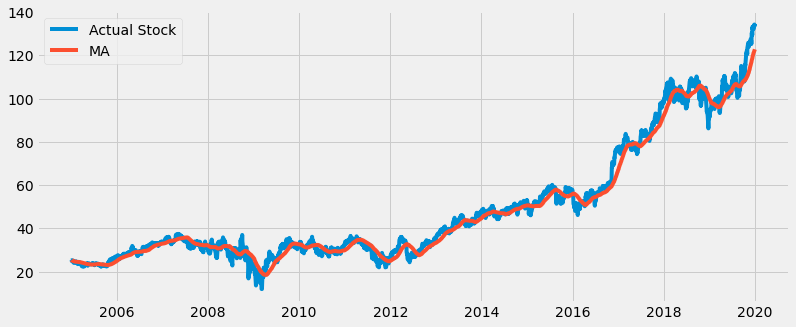

In [9]:
# A 100 days moving Average
plt.figure(figsize=(12,5))
plt.plot(jpm['Adj Close'], label='Actual Stock')
plt.plot(jpm.rolling('100D').mean()['Adj Close'], label='MA')
plt.legend()
plt.show();

#### 2.4 returns

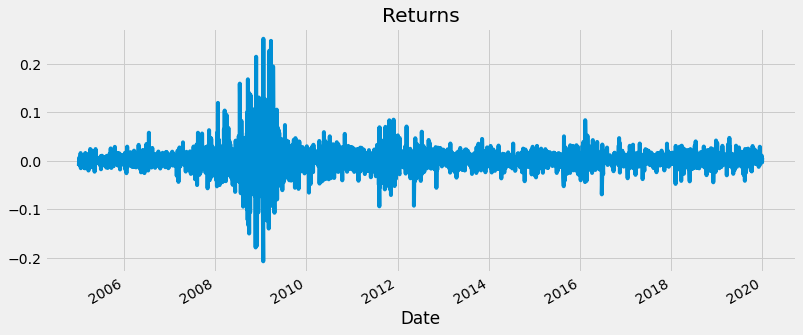

In [10]:
plt.title('Returns')
jpm['Adj Close'].pct_change().plot(figsize=(12,5))
plt.show();

### 3. Trends and Seasonality

<Figure size 1080x720 with 0 Axes>

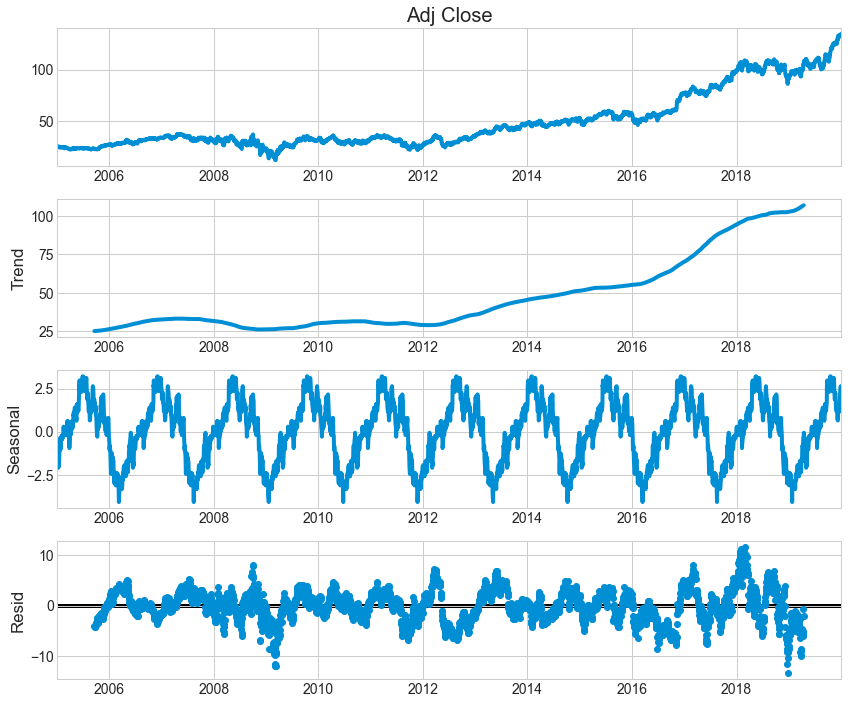

In [11]:
rcParams['figure.figsize'] = 12, 10
figures=sm.tsa.seasonal_decompose(jpm['Adj Close'], period=360)
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,10))
figures.plot();

### 4. Comparison with the Market

In [12]:
#S&P 500
sp=DataReader('^GSPC', data_source='yahoo', start=start, end=end)
sp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-01-03,1217.800049,1200.319946,1211.920044,1202.079956,1510800000,1202.079956
2005-01-04,1205.839966,1185.390015,1202.079956,1188.050049,1721000000,1188.050049
2005-01-05,1192.729980,1183.719971,1188.050049,1183.739990,1738900000,1183.739990
2005-01-06,1191.630005,1183.270020,1183.739990,1187.890015,1569100000,1187.890015
2005-01-07,1192.199951,1182.160034,1187.890015,1186.189941,1477900000,1186.189941


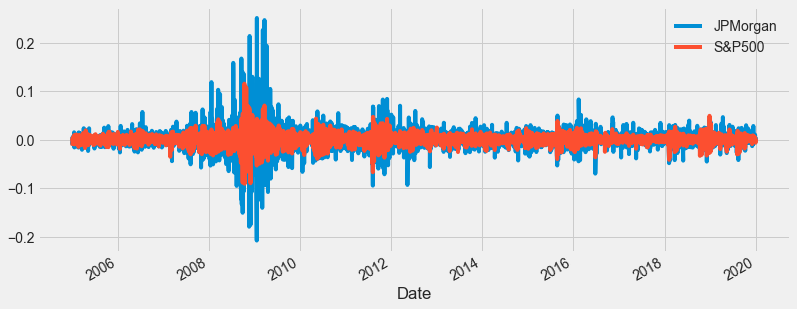

In [13]:
#Comparison of JPM daily returns compared to the S&P500
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
jpm['Adj Close'].pct_change().plot(label='JPMorgan')
sp['Adj Close'].pct_change().plot(label='S&P500')
plt.legend()

## We can see that they have almost the same behavior

Text(0, 0.5, 'JPMorgan')

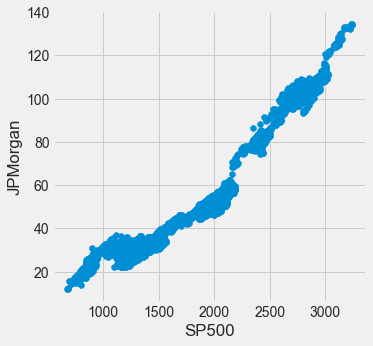

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(x=sp['Adj Close'], y=jpm['Adj Close'])
plt.xlabel('SP500')
plt.ylabel('JPMorgan')
## in this scatter plot we can see some correlation between these two variables

In [15]:
# we can also look at the correlation coefficient
corr_coef=sp['Adj Close'].corr(jpm['Adj Close'])
corr_coef

0.9650329779564244

### 5. AutoCorrrelation & Partial AutoCorrelation

In [16]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 360x360 with 0 Axes>

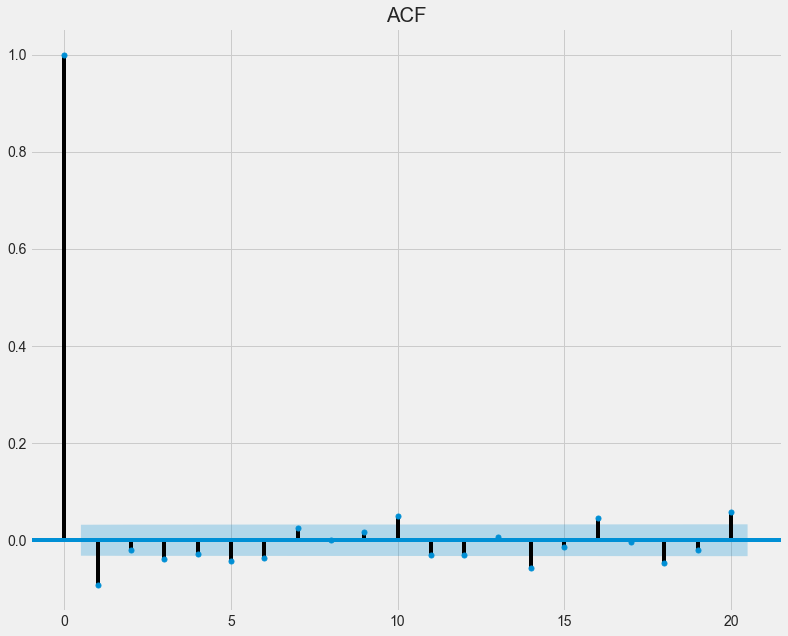

In [17]:
#ACF
plt.figure(figsize=(5,5))
plot_acf(jpm['Adj Close'].pct_change().dropna(), lags=20, alpha=0.05, title='ACF');
#Lags 1,3,5,6,10,14,16,18,20 are significant

<Figure size 360x360 with 0 Axes>

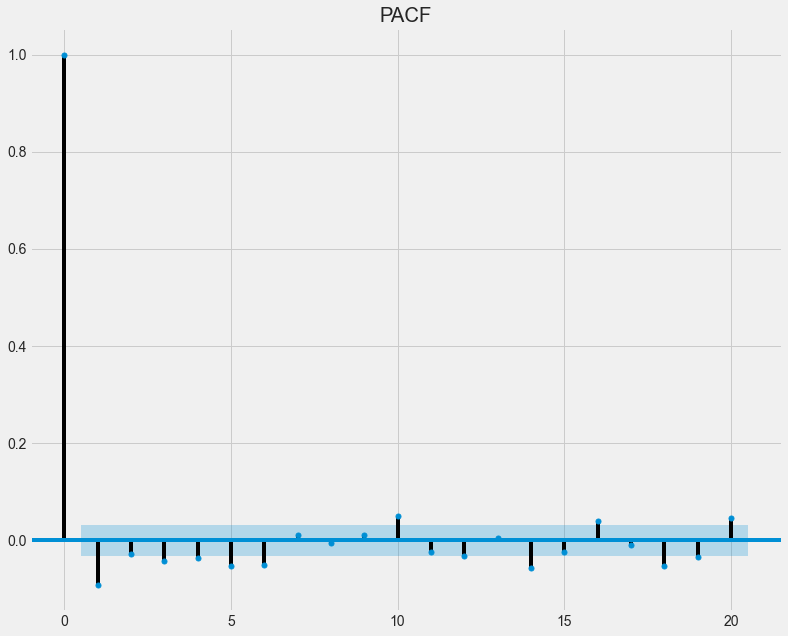

In [18]:
#PACF
plt.figure(figsize=(5,5))
plot_pacf(jpm['Adj Close'].pct_change().dropna(), lags=20, alpha=0.05, title='PACF');
#Lags 1,3,5,6,10,14,16,18,20 are significant

In [19]:
# Percentage return autocorrolation coefficient
jpm['Adj Close'].resample('M').mean().pct_change().autocorr()

0.24472881164875446

### 6. Random Walk

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
# Is our stock a random walk 

all_results=adfuller(jpm['Adj Close'])
all_results
## if a stock returns is a random walk 
## then todays price depends on the previous price plus some noise (white noise)

(2.351935691574812,
 0.9989858643500918,
 30,
 3744,
 {'1%': -3.432097806919567,
  '5%': -2.862312284650772,
  '10%': -2.5671810978277496},
 9445.466702364864)

In [22]:
p_value=all_results[1]
test_statistic=all_results[0]
(p_value,test_statistic)
##if the p_value is less than 5% (0.05) we can reject the null hypothesis
## which says that the stock is a random walk
## in this case the p_value is higher than 5% which means the stock is a random walk

(0.9989858643500918, 2.351935691574812)

### 7. Stationarity

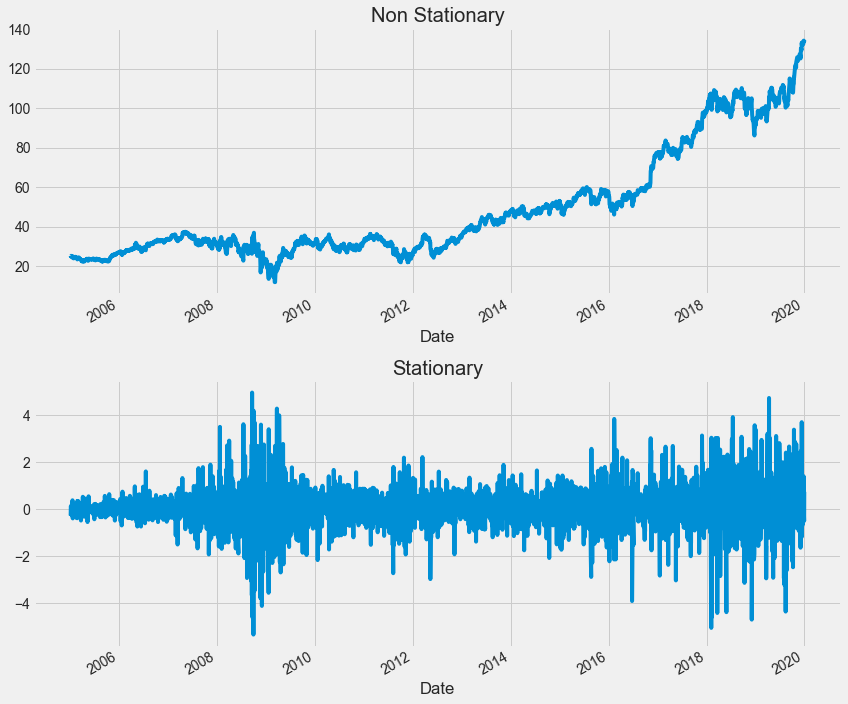

In [23]:
plt.subplot(2,1,1)
jpm['Adj Close'].plot(title='Non Stationary')

plt.subplot(2,1,2)
jpm['Adj Close'].diff().plot(title='Stationary')

plt.tight_layout()

In [24]:
jpm['Adj Close Stationary']=jpm['Adj Close'].diff()
jpm.head(3)

,High,Low,Open,Close,Volume,Adj Close,Adj Close Stationary
Date,,,,,,,
2005-01-03,39.689999,39.009998,39.480000,39.150002,14957900.0,25.323364,NaN
2005-01-04,39.060001,38.320000,38.980000,38.410000,11360900.0,25.062368,-0.260996
2005-01-05,38.919998,38.389999,38.599998,38.490002,9770200.0,25.114561,0.052193


### 8. Pre_Processing

In [25]:
# we have two datasets:
##1 the first  years of stock data (jpm_first_6years):train data, 
##2 the last last year of stock data (jpm_last_1year): test data
train=list(jpm_first_years['Adj Close'])
test=list(jpm_last_year['Adj Close'])

In [26]:
# we need to create two data sets X which will be arrays within an array and Y which will be just an array
def split_sequence(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [27]:
X_train, Y_train = split_sequence(train,14)
X_test, Y_test = split_sequence(test,14)

In [28]:
X_train.shape

(3509, 14)

In [29]:
len(X_train)

3509

In [30]:
#now we reshape the X's in order to bring them into shape the model can understand
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [31]:
#this kind of shape
X_train.shape

(3509, 14, 1)

In [32]:
X_test.shape

(238, 14, 1)

### 9. Modeling

In [33]:
# Calling the model
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fitting/training the data
model.fit(X_train, Y_train, epochs=200, batch_size=100, validation_data=(X_test, Y_test), verbose=0, shuffle=False)

In [35]:
# predicting
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [36]:
train_predict.shape

(3509, 1)

In [37]:
Y_train.shape

(3509,)

In [38]:
#Lets see how the model has performed 
print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict[:,0])))


Train Mean Absolute Error: 1.5739459768595876
Train Root Mean Squared Error: 1.8821028467294718
Test Mean Absolute Error: 2.0317771334608064
Test Root Mean Squared Error: 2.55628350472381


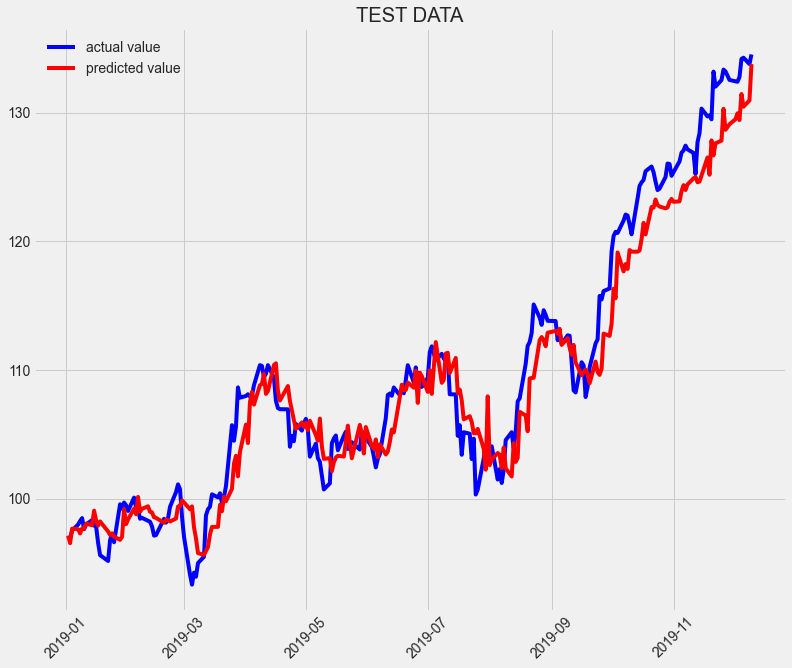

In [39]:
# Lets see the predicted values compares itself to the actual value
plt.title('TEST DATA')
plt.plot(jpm_last_year[0:238].index,Y_test,'b', label='actual value')
plt.plot(jpm_last_year.index[0:238],test_predict,'r', label='predicted value')
plt.legend()
plt.xticks(rotation=45);

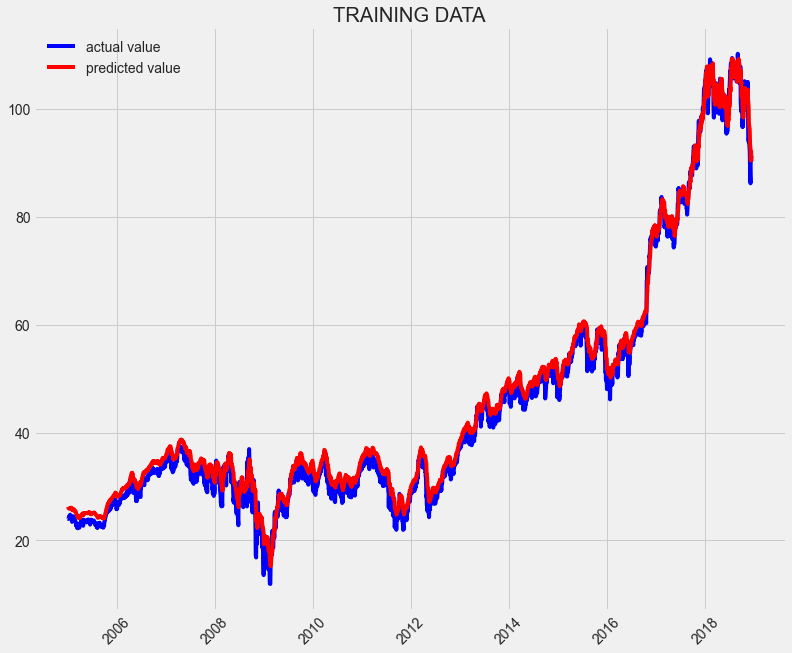

In [40]:
#Lets see how it does to the training data
plt.title('TRAINING DATA')
plt.plot(jpm_first_years[0:3509].index,Y_train,'b', label='actual value')
plt.plot(jpm_first_years.index[0:3509],train_predict,'r', label='predicted value')
plt.legend()
plt.xticks(rotation=45);

### 10. Saving the model

In [41]:
model.save('last_model.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: last_model.model\assets


In [42]:
model_jpm=tf.keras.models.load_model('last_model.model')
model_jpm

#### Using random 14 variables to predict one future price

Here I want to demonstrate that the model takes 14 variables as input in order to produce one future value

In [44]:
random_variables=np.random.random(14)*100

In [45]:
random_variables=random_variables.reshape(1,random_variables.shape[0],1)

In [47]:
predicted_value=model.predict(random_variables)

In [48]:
predicted_value

array([[21.48446]], dtype=float32)